# Recommendation System. Collaborative filtering

Most popular types of recommender systems are Collaborative Filtering and Content-Based. Former recommends products based on users' attitude to items, while latter makes recommendations based on similarities between items' attributes.

This notebook is about Collaborative Filtering. There are many approaches to CF. I'll try two approaches: Memory-Based and  Model-Based.

I use dataset "Restaurant & consumer data". It contains info for both types of recommender systems. In this notebook I'll use the basic data - users' ratings of restaurants.

___
Acknowledgements for data as requested:
Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Blanca Vargas-Govea, Juan Gabriel GonzÃ¡lez-Serna, Rafael Ponce-MedellÃn. Effects of relevant contextual features in the performance of a restaurant recommender system. In RecSysâ€™11: Workshop on Context Aware Recommender Systems (CARS-2011), Chicago, IL, USA, October 23, 2011.

1. [Data exploration](#datex)

2. [Memory-Based Collaborative Filtering](#mem)

3. [Model-based Collaborative Filtering](#mod)


In [47]:
#Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances, mean_squared_error
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline

## <a name="datex">Data exploration and transformation</a>

In [2]:
#Read data
data = pd.read_csv('d:/_python/Python projects/UCI/RCdata/rating_final.csv')

#Reading data. Input the path to the files instead of "../RCdata/rating_final.csv'".
#data = pd.read_csv('../RCdata/rating_final.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
userID            1161 non-null object
placeID           1161 non-null int64
rating            1161 non-null int64
food_rating       1161 non-null int64
service_rating    1161 non-null int64
dtypes: int64(4), object(1)
memory usage: 45.4+ KB


There is data about how users rated certain places: food, service and overall rating. I'll use only overall rating for my analysis. There are 1161 separate ratings.

In [4]:
data.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [5]:
data.rating.unique(), data.food_rating.unique(), data.service_rating.unique()

(array([2, 1, 0], dtype=int64),
 array([2, 1, 0], dtype=int64),
 array([2, 1, 0], dtype=int64))

Possible ratings are 2, 1, 0.

In [6]:
sum(data.groupby(['placeID'])['rating'].max() == 2)

118

118 restaurants from 130 got max rating at least once.

In [7]:
#le = LabelEncoder()
#train.userID = le.fit_transform(train.userID.values)
#le2 = LabelEncoder()
#train.placeID = le2.fit_transform(train.placeID.values)

In [8]:
#Now I create pivot table, because collaborative filtering works with this kind of data representation.
pivot = data.pivot_table(index='userID', columns='placeID', values='rating', fill_value=-1)
pivot = pivot.astype(float)
pivot

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
U1002,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
U1003,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
U1004,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0
U1005,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
U1006,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
U1007,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0
U1008,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
U1009,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
#And I'll need number of users and items.
users = pivot.shape[0]
items = pivot.shape[1]

In [10]:
sparsity=round(1-len(data)/float(users*items),3)
print ('The sparsity is ' + str(sparsity*100) + '%')

The sparsity is 93.5%


In [11]:
#Splitting data.
train_data, test_data = train_test_split(pivot, test_size=0.25, random_state = 10)

For modelling I need train and test data with the original dimensions, but splitting reduces dimensions. A straightforward way to retain original dimensions it is to create duplicate to original data and to nullify unselected rows, i. e. nullify rows with test data in train and vice versa.

In [13]:
train_data1 = pivot.copy()
test_data1 = pivot.copy()
for row in test_data.index:
    train_data1.loc[row] = 0
for row in train_data.index:
    test_data1.loc[row] = 0    

In [14]:
#Data needs to be coverted for numpy multiplications.
train_data = np.array(train_data1)
test_data = np.array(test_data1)

## <a name="mem">Memory-Based Collaborative Filtering</a>
Item-Item Collaborative Filtering: “Users who liked this item also liked …”

User-Item Collaborative Filtering: “Users who are similar to you also liked …”

http://online.cambridgecoding.com/notebooks/eWReNYcAfB/implementing-your-own-recommender-systems-in-python-2

In [15]:
user_similarity = pairwise_distances(train_data, metric='cosine')
item_similarity = pairwise_distances(train_data.T, metric='cosine')

In [16]:
def predict(ratings, sim, type):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        return (mean_user_rating[:, np.newaxis] + sim.dot(ratings_diff) / np.array([np.abs(sim).sum(axis=1)]).T)
    elif type == 'item':
        return (ratings.dot(sim) / np.array([np.abs(sim).sum(axis=1)])    )

In [17]:
item_pred = predict(train_data, item_similarity, type='item')
user_pred = predict(train_data, user_similarity, type='user')

In [18]:
def rmse(pred, target):
    pred = pred[target.nonzero()].flatten() 
    target = target[target.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, target))

In [19]:
print ('User-based CF RMSE: ' + str(rmse(user_pred, test_data)))
print ('Item-based CF RMSE: ' + str(rmse(item_pred, test_data)))

User-based CF RMSE: 1.0434369430661097
Item-based CF RMSE: 1.046293371803492


In [20]:
item_result = pd.DataFrame(item_pred, index=pivot.index, columns=pivot.columns)
user_result = pd.DataFrame(user_pred, index=pivot.index, columns=pivot.columns)
item_result

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,-0.768885,-0.777273,-0.760903,-0.829772,-0.782082,-0.796237,-0.768015,-0.792077,-0.776735,-0.785704,...,-0.764441,-0.819370,-0.807445,-0.871046,-0.781720,-0.787238,-0.781228,-0.831636,-0.819932,-0.769484
U1002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U1003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U1004,-0.717662,-0.728118,-0.707570,-0.786399,-0.734169,-0.751836,-0.716599,-0.746651,-0.727461,-0.738695,...,-0.707025,-0.774309,-0.756975,-0.828996,-0.763476,-0.740618,-0.733185,-0.850241,-0.775487,-0.718394
U1005,-0.708252,-0.720872,-0.695071,-0.764564,-0.729088,-0.751173,-0.707155,-0.744644,-0.720197,-0.734750,...,-0.691742,-0.839536,-0.789966,-0.825435,-0.733985,-0.737021,-0.728437,-0.799781,-0.802642,-0.709009
U1006,-0.744727,-0.750515,-0.741246,-0.834772,-0.752197,-0.760677,-0.743766,-0.758238,-0.749912,-0.754347,...,-0.753211,-0.754290,-0.752691,-0.820708,-0.780135,-0.755453,-0.750509,-0.776399,-0.759405,-0.745389
U1007,-0.721966,-0.736017,-0.706318,-0.838232,-0.746003,-0.771275,-0.720920,-0.763769,-0.735379,-0.752488,...,-0.710532,-0.801233,-0.800582,-0.887404,-0.774741,-0.754980,-0.745802,-0.813255,-0.837546,-0.722688
U1008,-0.868045,-0.867116,-0.872282,-0.847888,-0.863938,-0.860310,-0.867549,-0.861454,-0.866795,-0.862972,...,-0.868692,-0.868861,-0.901694,-0.837654,-0.860031,-0.862867,-0.862210,-0.855623,-0.924178,-0.868387
U1009,-0.592716,-0.612668,-0.570722,-0.711894,-0.626550,-0.662155,-0.591184,-0.651607,-0.611732,-0.635692,...,-0.589023,-0.687222,-0.653819,-0.834889,-0.643994,-0.639264,-0.626150,-0.736629,-0.695461,-0.593773


In [21]:
item_result.loc[item_result.index == 'U1004'].max(axis=1)

userID
U1004   -0.700152
dtype: float64

## <a name ="mod">Model-based Collaborative Filtering</a>

In [22]:
u, s, vt = svds(train_data, k = 15)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('User-based CF MSE: ' + str(rmse(X_pred, test_data)))

User-based CF MSE: 1.046293371803492


In [24]:
pd.DataFrame(X_pred, index=pivot.index, columns=pivot.columns)

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,-0.949919,-0.932579,-0.974893,-0.422373,-0.960756,-0.892380,-0.949944,-0.900699,-0.933334,-0.917065,...,-1.072103,-0.628879,-0.776303,0.302045,-1.123074,-0.939018,-0.917145,-0.807073,-0.712969,-0.965914
U1002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U1003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U1004,-1.063996,-0.907301,-1.023911,-0.609209,-1.059091,-1.126003,-1.083839,-1.056696,-1.024757,-1.078095,...,-1.167392,-1.050507,-1.200491,-1.680077,-0.222356,-1.010660,-1.146111,1.071930,-1.150383,-1.017932
U1005,-1.023101,-1.019242,-1.028180,-1.182084,-1.014182,-1.007206,-1.026832,-1.009786,-1.011369,-1.016263,...,-1.093842,0.471971,-0.484030,-1.031093,-1.023394,-1.005810,-1.024203,-0.794537,-0.740281,-1.020925
U1006,-0.973920,-0.874374,-0.956092,-0.077530,-0.994925,-0.998759,-0.987177,-0.956192,-0.943811,-0.975014,...,-1.039047,-0.748767,-0.871292,-0.091424,-0.469292,-0.952924,-1.018788,-0.673023,-0.943435,-0.959363
U1007,-1.057993,-1.061860,-1.053105,-0.108660,-1.054101,-1.073485,-1.061943,-1.067181,-1.054382,-1.067752,...,-1.030157,-0.848381,-0.494117,0.634376,-0.614748,-1.050773,-1.075617,-1.383617,-0.160131,-1.050773
U1008,-1.003709,-0.823597,-0.962091,-1.195005,-1.050605,-1.077932,-1.025128,-0.992632,-0.961770,-1.019210,...,-0.972065,-1.041268,-0.086934,-1.078187,-1.075421,-0.983662,-1.093366,-0.895172,0.840296,-0.973360
U1009,-1.015597,-0.984005,-1.000672,-1.450586,-1.023261,-1.046764,-1.021618,-1.025753,-1.008254,-1.028441,...,-0.747583,-0.952657,-1.130364,0.418135,-0.868513,-1.011441,-1.046927,-0.538413,-0.848041,-1.005493


### Alternating Least Squares
http://online.cambridgecoding.com/notebooks/mhaller/predicting-user-preferences-in-python-using-alternating-least-squares

In [25]:
R = train_data
T = test_data

In [26]:
# Index matrix for training data
I = R.copy()
I[I > -1] = 1
I[I == -1] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > -1] = 1
I2[I2 == -1] = 0

In [27]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [30]:
lmbda = 0.1 # Regularisation weight
k = 20 # Dimensionality of latent feature space
m, n = R.shape # Number of users and items
n_epochs = 100 # Number of epochs

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [31]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print ("[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse))
    
print ("Algorithm converged")

[Epoch 1/100] train error: 1.386757, test error: 1.818333
[Epoch 2/100] train error: 0.510559, test error: 5.902789
[Epoch 3/100] train error: 0.509372, test error: 6.031668
[Epoch 4/100] train error: 0.509115, test error: 6.089606
[Epoch 5/100] train error: 0.508188, test error: 6.122559
[Epoch 6/100] train error: 0.507431, test error: 6.143044
[Epoch 7/100] train error: 0.506940, test error: 6.156651
[Epoch 8/100] train error: 0.506646, test error: 6.166163
[Epoch 9/100] train error: 0.506474, test error: 6.173070
[Epoch 10/100] train error: 0.506374, test error: 6.178231
[Epoch 11/100] train error: 0.506317, test error: 6.182169
[Epoch 12/100] train error: 0.506285, test error: 6.185223
[Epoch 13/100] train error: 0.506268, test error: 6.187622
[Epoch 14/100] train error: 0.506259, test error: 6.189526
[Epoch 15/100] train error: 0.506256, test error: 6.191050
[Epoch 16/100] train error: 0.506256, test error: 6.192277
[Epoch 17/100] train error: 0.506259, test error: 6.193271
[Epoch

In [32]:
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

In [33]:
R_hat

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,0.314537,0.081521,0.221203,0.886951,0.373857,0.707817,0.270244,0.583911,0.346910,0.482109,...,0.162704,0.832329,0.888352,0.721038,0.510701,0.404954,0.292476,0.969510,1.136089,0.315594
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.646261,0.320610,0.468232,1.266901,0.728921,1.337116,0.605339,1.231764,0.713050,1.002471,...,0.465640,1.047531,1.194309,1.840075,1.066509,0.689892,0.685736,1.557048,1.772777,0.515525
4,0.502568,0.130060,0.361895,0.981302,0.530744,1.028599,0.483227,0.953655,0.551582,0.763980,...,0.354668,0.759340,0.951820,1.293190,0.829808,0.462166,0.567650,1.045746,1.305767,0.391554
5,0.482350,0.275037,0.354368,0.871915,0.580472,1.072172,0.404072,0.928786,0.542544,0.778402,...,0.272864,0.877529,0.614937,1.145627,0.686262,0.655047,0.402835,1.070749,1.366802,0.455857
6,0.273004,0.129417,0.193634,0.646556,0.307377,0.555460,0.267726,0.511625,0.297059,0.406303,...,0.197185,0.456247,0.666274,0.816713,0.487257,0.299538,0.323930,0.751330,0.834044,0.248482
7,0.343462,0.181463,0.252226,0.677628,0.507239,0.823811,0.250373,0.659670,0.391777,0.574041,...,0.132434,0.866915,0.534389,0.475294,0.435653,0.619025,0.203549,0.848704,1.069617,0.372555
8,0.492430,0.113257,0.360422,0.651541,0.463638,1.013546,0.462222,0.946913,0.545537,0.768300,...,0.350447,0.741256,0.594597,1.409236,0.742658,0.421584,0.521732,0.802279,1.125488,0.385121
9,0.293255,0.123652,0.206704,0.762227,0.303694,0.569530,0.307076,0.547543,0.315538,0.421633,...,0.233769,0.337236,0.738563,0.881311,0.564318,0.246432,0.394635,0.761534,0.856401,0.230145


In [34]:
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

ratings

,Actual Rating,Predicted Rating
29,1.0,0.775401
59,2.0,1.200709


In [35]:
predictions = R_hat.loc[16,R.loc[16,:] == -1] # Predictions for movies that the user 17 hasn't rated yet
top5 = predictions.sort_values(ascending=False).head(n=5)
recommendations = pd.DataFrame(data=top5)
recommendations.columns = ['Predicted Rating']

recommendations

,Predicted Rating
98,1.263452
91,1.246690
80,1.225093
85,1.210647
110,1.209262


In [36]:
for col in R_hat.columns:
    if R_hat[col].mean() > 0.7:
        print(col, R_hat[col].mean())

31 0.7890940553197335
33 0.7126511298617324
42 0.7416217562042935
51 0.7901480301799991
52 0.7665581424704492
78 0.7816514687573026
79 0.7289477114015634
85 0.7987346930816869
91 0.8221941400724381
92 0.7226566429087531
98 0.752709986139962
101 0.7200360282266068
102 0.7827066054624702
104 0.7181225324907495
106 0.7310999530556963
110 0.8144360006223493
117 0.8168858630347441
118 0.7410660341036881
123 0.7619616157506327
128 0.7574421271191215


http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/

In [37]:
Q = pivot.values
W = Q > -1
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [38]:
lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 20

In [39]:
X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [40]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [41]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors), np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors), np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    print('{}th iteration is completed'.format(ii))
weighted_Q_hat = np.dot(X,Y)
#print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed


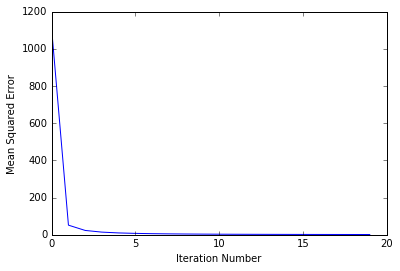

In [48]:
plt.plot(weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [46]:
weighted_Q_hat

array([[-0.03001527,  0.09394188,  0.27070464, ...,  0.20235264,
         0.74367453, -0.02387958],
       [ 0.04239453, -0.00566392,  0.14065077, ...,  1.00014121,
         0.76662759, -0.00943498],
       [-0.03590937,  0.16942722,  0.08804099, ...,  0.78875107,
        -0.64062058,  0.07287539],
       ..., 
       [ 0.27019917,  0.11427045,  0.26244828, ...,  1.75894972,
         0.62608085,  0.16621508],
       [ 0.04873204, -0.16827429,  0.06728543, ...,  0.44190507,
        -0.01064402,  0.02018766],
       [ 0.12775551,  0.00626213,  0.13577125, ...,  1.18456682,
         0.32693666,  0.0963441 ]])